In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col, sum as spark_sum, first, log2, udf
from pyspark.sql.types import DoubleType
import numpy as np

# 1. Load and Prepare Data
# Using the KDD Cup dataset from the lab
cols = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label'
]
raw_df = spark.read.csv('./lab/kddcup.data_10_percent_corrected.csv', header=False, inferSchema=True).toDF(*cols)

# Split data into training and testing sets
train_df, test_df = raw_df.randomSplit([0.7, 0.3], seed=42)
train_df.cache()
test_df.cache()

# 2. Define the Feature Engineering and K-Means Pipeline
# Create a pipeline to handle one-hot encoding for categorical features,
# assemble them with numerical features, and scale the final feature vector.

# Identify categorical and numerical columns
categorical_cols = ["protocol_type", "service", "flag"]
numerical_cols = [c for c in raw_df.columns if c not in categorical_cols + ["label"]]

# Create stages for StringIndexing and OneHotEncoding
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep") for c in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{c}_idx", outputCol=f"{c}_vec") for c in categorical_cols]

# Assemble all feature columns into a single vector
encoded_cols = [f"{c}_vec" for c in categorical_cols]
assembler = VectorAssembler(inputCols=numerical_cols + encoded_cols, outputCol="features")

# Scale features to have zero mean and unit variance
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

# Define the K-Means model
# Note: The optimal 'k' (e.g., 110) was found using the elbow method in the original notebook.
kmeans = KMeans(featuresCol='scaled_features', predictionCol='cluster', k=110, seed=42)

# Chain all stages into a single pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler, kmeans])

# 3. Train the Model and Get Cluster Centers
print("Training K-Means model...")
model = pipeline.fit(train_df)
print("Training complete.")

# Extract the cluster centers from the trained model
cluster_centers = model.stages[-1].clusterCenters()

# 4. Transform the Test Data and Identify Anomalies
print("Transforming test data and identifying anomalies...")
kmod_test = model.transform(test_df)

# Define a UDF to calculate the Euclidean distance of each point to its assigned cluster center
def euclidean_distance(features, cluster_id):
    center_vector = cluster_centers[cluster_id]
    return float(np.linalg.norm(np.array(features) - center_vector))

distance_udf = udf(euclidean_distance, DoubleType())

# Apply the UDF to calculate distances
kmod_test_with_dist = kmod_test.withColumn(
    'distance_to_center', distance_udf(col('scaled_features'), col('cluster'))
)

# 5. Evaluate and Label Anomalies
# Calculate the mean and standard deviation of distances for each cluster
distance_stats = kmod_test_with_dist.groupBy('cluster').agg(
    mean('distance_to_center').alias('mean_dist'),
    stddev('distance_to_center').alias('std_dist')
)

# Join the stats back to the main test dataframe
kmod_test_with_stats = kmod_test_with_dist.join(distance_stats, on='cluster')

# Label points as anomalies if their distance is far from the cluster center
# A common threshold is a certain number of standard deviations from the mean.
threshold_factor = 3
anomalies_df = kmod_test_with_stats.withColumn(
    "is_anomaly",
    (col('distance_to_center') > (col('mean_dist') + threshold_factor * col('std_dist'))).cast("integer")
)

print("\n--- Anomaly Detection Results ---")
anomalies_df.select("label", "cluster", "distance_to_center", "is_anomaly").show(10)

# Evaluate the effectiveness by comparing model-flagged anomalies to true attack labels
print("\nBreakdown of detected anomalies by true label:")
anomalies_df.filter(col('is_anomaly') == 1).groupBy('label').count().orderBy(col('count').desc()).show()

total_detected = anomalies_df.filter(col('is_anomaly') == 1).count()
total_test = anomalies_df.count()
print(f"\nTotal points in test set: {total_test}")
print(f"Total points flagged as anomalies: {total_detected} ({100 * total_detected / total_test:.2f}%)")

# Unpersist the cached dataframes
train_df.unpersist()
test_df.unpersist()


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/10/09 08:07:58 WARN Utils: Your hostname, dbl-07, resolves to a loopback address: 127.0.1.1; using 172.16.58.87 instead (on interface eno1)
25/10/09 08:07:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/09 08:07:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from pyspark.sql import SparkSession
spark= SparkSession.builder.getOrCreate()

In [3]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [4]:
noCol_data= spark.read.option("InferSchema",True).option("header",False).csv("kddcup.data_10_percent_corrected.csv")

In [5]:
cols= ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
        'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
        'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
        'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
        'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
        'label' 
]

In [6]:
len(cols)

42

In [7]:
noCol_data.count()

494021

In [8]:
df= noCol_data.toDF(*cols)
df.show(3)

+--------+-------------+-------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate|dst_hos

25/10/09 08:13:13 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [9]:
df.printSchema()

root
 |-- duration: integer (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: integer (nullable = true)
 |-- dst_bytes: integer (nullable = true)
 |-- land: integer (nullable = true)
 |-- wrong_fragment: integer (nullable = true)
 |-- urgent: integer (nullable = true)
 |-- hot: integer (nullable = true)
 |-- num_failed_logins: integer (nullable = true)
 |-- logged_in: integer (nullable = true)
 |-- num_compromised: integer (nullable = true)
 |-- root_shell: integer (nullable = true)
 |-- su_attempted: integer (nullable = true)
 |-- num_root: integer (nullable = true)
 |-- num_file_creations: integer (nullable = true)
 |-- num_shells: integer (nullable = true)
 |-- num_access_files: integer (nullable = true)
 |-- num_outbound_cmds: integer (nullable = true)
 |-- is_host_login: integer (nullable = true)
 |-- is_guest_login: integer (nullable = true)
 |-- count: integer (nullable = true

In [10]:
noOfLabels=(df.groupBy(col('label')).count()).count()

In [11]:
df.groupBy(col('label')).count().orderBy(col('count').desc()).show(noOfLabels)

+----------------+------+
|           label| count|
+----------------+------+
|          smurf.|280790|
|        neptune.|107201|
|         normal.| 97278|
|           back.|  2203|
|          satan.|  1589|
|        ipsweep.|  1247|
|      portsweep.|  1040|
|    warezclient.|  1020|
|       teardrop.|   979|
|            pod.|   264|
|           nmap.|   231|
|   guess_passwd.|    53|
|buffer_overflow.|    30|
|           land.|    21|
|    warezmaster.|    20|
|           imap.|    12|
|        rootkit.|    10|
|     loadmodule.|     9|
|      ftp_write.|     8|
|       multihop.|     7|
|            phf.|     4|
|           perl.|     3|
|            spy.|     2|
+----------------+------+



### dropping non numeric, unnecessary columns

In [12]:
numeric_only= df.drop('protocol_type', 'service', 'flag')
print(f"No of columns in after the drop: {len(numeric_only.columns)}")

No of columns in after the drop: 39


### feature vector and kmeans instance creation

In [13]:
from pyspark.ml.feature import VectorAssembler , StandardScaler
from pyspark.ml.clustering import KMeans

In [113]:
feat_input=numeric_only.columns
#feat_input[:-1]

In [114]:
assembler= VectorAssembler(inputCols=feat_input[:-1], outputCol='features')
assembler

VectorAssembler_19352e418dbb

In [144]:
# to remove the dominance of large scale features we need to scale down to a standard value for all the features
scaler= StandardScaler(inputCol='features', outputCol='scaled_features')

In [146]:
kmeans_instance= KMeans(featuresCol='scaled_features', predictionCol='clusters', k=5)

### Pipeline 

In [15]:
from pyspark.ml import Pipeline

In [148]:
pipe= Pipeline(stages=[assembler,scaler, kmeans_instance])

In [149]:
model= pipe.fit(numeric_only)

In [150]:
kmodel= model.transform(numeric_only)

In [151]:
model.stages[1]

StandardScalerModel: uid=StandardScaler_a1fa4ac3c644, numFeatures=38, withMean=false, withStd=true

In [152]:
model.stages[-1].clusterCenters()

[array([6.73160520e-02, 2.11425583e-03, 3.39024608e-02, 0.00000000e+00,
        5.87613907e-02, 9.63191402e-04, 5.68234804e-02, 1.70991331e-03,
        5.44790988e-01, 7.34583106e-03, 1.35819894e-02, 5.44867492e-03,
        7.22128141e-03, 1.43122960e-02, 1.30036806e-02, 3.60795621e-02,
        0.00000000e+00, 0.00000000e+00, 4.77099464e-02, 1.78308663e+00,
        1.54606782e+00, 1.12765731e-03, 1.16096786e-03, 1.69105727e-03,
        4.05407196e-03, 2.57283264e+00, 1.87484489e-02, 2.43235710e-01,
        3.53844422e+00, 2.27457758e+00, 2.34006083e+00, 1.16618989e-01,
        1.61834545e+00, 1.51985922e-01, 1.66163598e-03, 6.81961271e-04,
        9.17323141e-03, 7.26294463e-03]),
 array([5.41103893e-02, 8.01772579e-03, 6.81339846e-04, 0.00000000e+00,
        1.61065487e-02, 0.00000000e+00, 3.26523255e-03, 7.24889055e-04,
        7.34497046e-03, 7.50697103e-05, 0.00000000e+00, 0.00000000e+00,
        6.09249914e-04, 7.00091277e-04, 0.00000000e+00, 3.08373486e-04,
        0.00000000e+00

In [158]:
kmodel.groupBy("clusters").count().show()

+--------+------+
|clusters| count|
+--------+------+
|       1| 88889|
|       3| 28278|
|       4|    22|
|       2|     2|
|       0|376830|
+--------+------+



In [157]:
kmodel.groupBy("clusters","label").count().orderBy("clusters", "count",ascending=False).show(50)

+--------+----------------+------+
|clusters|           label| count|
+--------+----------------+------+
|       4|           land.|    21|
|       4|         normal.|     1|
|       3|        neptune.| 20457|
|       3|         normal.|  5389|
|       3|          satan.|  1274|
|       3|      portsweep.|  1004|
|       3|        ipsweep.|    90|
|       3|   guess_passwd.|    51|
|       3|           back.|    12|
|       3|    warezclient.|     1|
|       2|         normal.|     1|
|       2|      ftp_write.|     1|
|       1|        neptune.| 86744|
|       1|         normal.|  1747|
|       1|          satan.|   189|
|       1|           nmap.|   103|
|       1|       teardrop.|    65|
|       1|      portsweep.|    28|
|       1|    warezclient.|     6|
|       1|           imap.|     6|
|       1|   guess_passwd.|     1|
|       0|          smurf.|280790|
|       0|         normal.| 90140|
|       0|           back.|  2191|
|       0|        ipsweep.|  1157|
|       0|    warezc

In [155]:
kmodel.crosstab("clusters", "label").show(truncate=False)


+--------------+-----+----------------+----------+-------------+-----+--------+-----+-----------+---------+--------+-----+-------+-----+----+----+----------+--------+------+------+----+---------+------------+------------+
|clusters_label|back.|buffer_overflow.|ftp_write.|guess_passwd.|imap.|ipsweep.|land.|loadmodule.|multihop.|neptune.|nmap.|normal.|perl.|phf.|pod.|portsweep.|rootkit.|satan.|smurf.|spy.|teardrop.|warezclient.|warezmaster.|
+--------------+-----+----------------+----------+-------------+-----+--------+-----+-----------+---------+--------+-----+-------+-----+----+----+----------+--------+------+------+----+---------+------------+------------+
|3             |12   |0               |0         |51           |0    |90      |0    |0          |0        |20457   |0    |5389   |0    |0   |0   |1004      |0       |1274  |0     |0   |0        |1           |0           |
|0             |2191 |30              |7         |1            |6    |1157    |0    |9          |7        |0    

In [159]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(featuresCol='scaled_features', predictionCol='clusters')
silhouette = evaluator.evaluate(kmodel)
print("Silhouette score =", silhouette)


Silhouette score = 0.5954205438470792


## with encoding func and using 3 categorical columns

In [33]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
import matplotlib.pyplot as plt

In [16]:
df2= df.alias("df2")

In [17]:
def encoding_pipe(input_col):
    indexer= StringIndexer(inputCol=input_col, outputCol=input_col+'-indexed')
    encoder= OneHotEncoder(inputCol=input_col+'-indexed', outputCol=input_col+'_vector')
    piped= Pipeline(stages=[indexer,encoder])

    return piped, input_col+'_vector'

In [31]:
def clustering_score(df,k):
    prot_pipe, prot_col= encoding_pipe("protocol_type")
    service_pipe, service_col= encoding_pipe("service")
    flag_pipe, flag_col= encoding_pipe("flag")

    assemble_cols= [c for c in df.columns if c not in ["protocol_type", "service","flag", "label"]]+ [prot_col,service_col, flag_col]

    assembler= VectorAssembler(inputCols=assemble_cols, outputCol='features')

    scaler= StandardScaler(inputCol= 'features', outputCol='scaled_features', withMean=False, withStd=True)

    kmeans= KMeans(featuresCol='scaled_features', predictionCol='cluster',k=k, tol=1e-5, maxIter=50)

    pipe_func= Pipeline(stages=[prot_pipe,service_pipe,flag_pipe, assembler, scaler, kmeans])

    model= pipe_func.fit(df)

    return model, model.stages[-1].summary.trainingCost


In [32]:
costs=[]
ks= list(range(60,221,10))
for k in ks:
    mod,cst= clustering_score(df2,k)
    costs.append(cst)
    print(f"For k={k}, cost= {cst}")


For k=60, cost= 17578273.72679865


For k=70, cost= 12965196.73960674


For k=80, cost= 9141746.940497063


For k=90, cost= 7364809.546924012


For k=100, cost= 2721634.9460902573


For k=110, cost= 1760897.33169811


For k=120, cost= 1615009.2631761488


For k=130, cost= 1297728.6629704004


For k=140, cost= 1112344.1007328127


For k=150, cost= 995802.0269485968


For k=160, cost= 900704.4526526444


For k=170, cost= 846431.3052828464


For k=180, cost= 756998.0675800475


For k=190, cost= 694303.7836822461


For k=200, cost= 635685.4460741978


For k=210, cost= 601610.5408926205


For k=220, cost= 580736.595396374


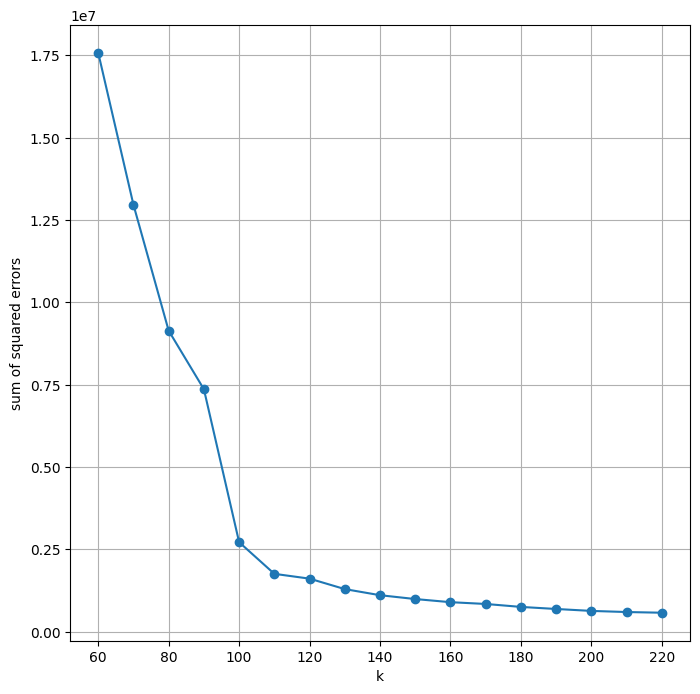

In [35]:
plt.figure(figsize=(8,8))
plt.plot(ks,costs,marker='o')
plt.xlabel('k')
plt.ylabel('sum of squared errors')
plt.grid(True)
plt.show()

In [24]:
k=110
fin_model, cost_fin= clustering_score(df2,k)

In [25]:
kmod= fin_model.transform(df2)

In [26]:
kmod.show()

+--------+-------------+-------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------+---------------------+--------------------+---------------+--------------+------------+--------------+--------------------+--------------------+-------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_

In [37]:
kmod.groupBy('cluster').count().show(30)

+-------+------+
|cluster| count|
+-------+------+
|     31| 19376|
|     85|   102|
|     65|   156|
|     53|    57|
|     78|   105|
|    108|    14|
|     34|   102|
|    101|    98|
|     81|    45|
|     28|   104|
|     76|    99|
|     27|  5242|
|     26|    99|
|     44|    39|
|    103|     5|
|     12|   115|
|     91|  1562|
|     22|    99|
|     93|   112|
|     47|  4130|
|      1|281147|
|     52|     4|
|     13|     2|
|     86|   293|
|      6|     2|
|     16|   106|
|      3|   109|
|     40|  3987|
|     20|    19|
|     94|     7|
+-------+------+
only showing top 30 rows


### weighted entropy

In [39]:
from pyspark.sql.window import Window

In [47]:
df_ent= kmod.groupBy('cluster','label').count()
df_ent.show(2)

+-------+--------+-----+
|cluster|   label|count|
+-------+--------+-----+
|     70|neptune.|   98|
|     97|  satan.|    1|
+-------+--------+-----+
only showing top 2 rows


In [48]:
w= Window.partitionBy('cluster')

df_ent= df_ent.withColumn('cluster_total', sum(col('count')).over(w))

In [49]:
df_ent.show(5)

+-------+----------+------+-------------+
|cluster|     label| count|cluster_total|
+-------+----------+------+-------------+
|      0|  neptune.| 82342|        82357|
|      0|portsweep.|    15|        82357|
|      1|      pod.|     5|       281147|
|      1|    smurf.|280787|       281147|
|      1|     nmap.|     1|       281147|
+-------+----------+------+-------------+
only showing top 5 rows


In [52]:
df_ent=df_ent.withColumn('probab_col', col('count')/col('cluster_total'))

In [53]:
df_ent.show(5)

+-------+----------+------+-------------+--------------------+
|cluster|     label| count|cluster_total|          probab_col|
+-------+----------+------+-------------+--------------------+
|      0|  neptune.| 82342|        82357|  0.9998178661194556|
|      0|portsweep.|    15|        82357|1.821338805444589E-4|
|      1|      pod.|     5|       281147|1.778429078026797...|
|      1|    smurf.|280787|       281147|  0.9987195310638207|
|      1|     nmap.|     1|       281147|3.556858156053594...|
+-------+----------+------+-------------+--------------------+
only showing top 5 rows


In [54]:
df_ent= df_ent.withColumn('entropy_term', -col('probab_col')*log2(col('probab_col')))

In [55]:
df_ent.show(5)

+-------+----------+------+-------------+--------------------+--------------------+
|cluster|     label| count|cluster_total|          probab_col|        entropy_term|
+-------+----------+------+-------------+--------------------+--------------------+
|      0|  neptune.| 82342|        82357|  0.9998178661194556|2.627397157051565E-4|
|      0|portsweep.|    15|        82357|1.821338805444589E-4|0.002262596936897712|
|      1|      pod.|     5|       281147|1.778429078026797...|2.806189828119352...|
|      1|    smurf.|280787|       281147|  0.9987195310638207|0.001846142957204...|
|      1|     nmap.|     1|       281147|3.556858156053594...|6.438256544445715E-5|
+-------+----------+------+-------------+--------------------+--------------------+
only showing top 5 rows


In [56]:
entropy_df= df_ent.groupBy('cluster').agg(sum(col('entropy_term')).alias('entropy'),
                                          first('cluster_total').alias('cluster_count'))

In [57]:
entropy_df.show(5)

+-------+--------------------+-------------+
|cluster|             entropy|cluster_count|
+-------+--------------------+-------------+
|      0|0.002525336652602869|        82357|
|      1| 0.01446838598061617|       281147|
|      2| 0.13110652958234503|         1265|
|      3| 0.13206535647488304|          109|
|      4|                 0.0|           89|
+-------+--------------------+-------------+
only showing top 5 rows


In [58]:
total= df_ent.agg(sum(col('count'))).collect()

In [65]:
tot=total[0][0]

In [70]:
w_ent_df= entropy_df.withColumn('weighted_entropy',(col('cluster_count')/tot)*col('entropy')).agg(sum('weighted_entropy').alias('total_entropy')).collect()[0][0]

In [71]:
w_ent_df

0.06349159961036571

In [73]:
anomalies= entropy_df.filter((col('entropy')>0.45) & (col('cluster_count')<80))

In [74]:
anomalies.show()

+-------+------------------+-------------+
|cluster|           entropy|cluster_count|
+-------+------------------+-------------+
|     10|1.2059413017339653|           24|
|     13|               1.0|            2|
|     25|0.5225593745369408|           17|
|     37|1.1567796494470395|           10|
|     41|1.5566567074628228|            7|
|     48| 1.645461844238322|           40|
|     53|0.6614467366902077|           57|
|     57|0.6840384356390417|           11|
|     80| 0.863120568566631|            7|
|     90|               1.0|            2|
|     94|1.3787834934861756|            7|
|     99|0.7219280948873623|            5|
+-------+------------------+-------------+



## To check anomalies 

In [79]:
df2.show()

+--------+-------------+-------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate|dst_hos

In [102]:
train, test= df2.randomSplit([0.7,0.3],seed=42)
train.cache()
test.cache()

DataFrame[duration: int, protocol_type: string, service: string, flag: string, src_bytes: int, dst_bytes: int, land: int, wrong_fragment: int, urgent: int, hot: int, num_failed_logins: int, logged_in: int, num_compromised: int, root_shell: int, su_attempted: int, num_root: int, num_file_creations: int, num_shells: int, num_access_files: int, num_outbound_cmds: int, is_host_login: int, is_guest_login: int, count: int, srv_count: int, serror_rate: double, srv_serror_rate: double, rerror_rate: double, srv_rerror_rate: double, same_srv_rate: double, diff_srv_rate: double, srv_diff_host_rate: double, dst_host_count: int, dst_host_srv_count: int, dst_host_same_srv_rate: double, dst_host_diff_srv_rate: double, dst_host_same_src_port_rate: double, dst_host_srv_diff_host_rate: double, dst_host_serror_rate: double, dst_host_srv_serror_rate: double, dst_host_rerror_rate: double, dst_host_srv_rerror_rate: double, label: string]

In [103]:
model_final_ano, costi= clustering_score(train,110)

In [104]:
kmod_train= model_final_ano.transform(train)

In [105]:
kmod_train.show(2)

+--------+-------------+-------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+--------+---------------------+--------------------+---------------+--------------+------------+--------------+--------------------+--------------------+-------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is

In [106]:
df_ent_train= kmod_train.groupBy('cluster','label').count()
df_ent_train.show(2)

+-------+--------+-----+
|cluster|   label|count|
+-------+--------+-----+
|     85|  satan.|    2|
|     70|neptune.|   75|
+-------+--------+-----+
only showing top 2 rows


In [107]:
w2= Window.partitionBy('cluster')

df_ent_train= df_ent_train.withColumn('cluster_total', sum(col('count')).over(w2))

In [108]:
df_ent_train.show(2)

+-------+----------+-----+-------------+
|cluster|     label|count|cluster_total|
+-------+----------+-----+-------------+
|      0|  neptune.|25489|        25503|
|      0|portsweep.|   14|        25503|
+-------+----------+-----+-------------+
only showing top 2 rows


In [109]:
df_ent_train=df_ent_train.withColumn('probab_col', col('count')/col('cluster_total'))

In [110]:
df_ent_train.show(5)

+-------+----------+------+-------------+--------------------+
|cluster|     label| count|cluster_total|          probab_col|
+-------+----------+------+-------------+--------------------+
|      0|  neptune.| 25489|        25503|   0.999451044975101|
|      0|portsweep.|    14|        25503|5.489550248990315E-4|
|      1|      pod.|     9|       196650|4.576659038901602E-5|
|      1|    smurf.|196407|       196650|  0.9987643020594966|
|      1|     nmap.|     1|       196650|5.085176709890669E-6|
+-------+----------+------+-------------+--------------------+
only showing top 5 rows


In [111]:
df_ent_train= df_ent_train.withColumn('entropy_term', -col('probab_col')*log2(col('probab_col')))

In [112]:
df_ent_train.show(5)

+-------+----------+------+-------------+--------------------+--------------------+
|cluster|     label| count|cluster_total|          probab_col|        entropy_term|
+-------+----------+------+-------------+--------------------+--------------------+
|      0|  neptune.| 25489|        25503|   0.999451044975101|7.917572730614567E-4|
|      0|portsweep.|    14|        25503|5.489550248990315E-4|0.005945745282041122|
|      1|      pod.|     9|       196650|4.576659038901602E-5|6.597412201041339E-4|
|      1|    smurf.|196407|       196650|  0.9987643020594966|0.001781633375665...|
|      1|     nmap.|     1|       196650|5.085176709890669E-6|8.942420880100501E-5|
+-------+----------+------+-------------+--------------------+--------------------+
only showing top 5 rows


In [113]:
entropy_df_train= df_ent_train.groupBy('cluster').agg(sum(col('entropy_term')).alias('entropy'),
                                          first('cluster_total').alias('cluster_count'))

In [118]:
entropy_df_train.show()

+-------+--------------------+-------------+
|cluster|             entropy|cluster_count|
+-------+--------------------+-------------+
|      0|0.006737502555102579|        25503|
|      1|0.014143379711665125|       196650|
|      2|  0.3546144360647215|           72|
|      3|  0.0922772477445739|           85|
|      4| 0.16702680404522807|           81|
|      5|                 0.0|           71|
|      6| 0.09140162014739274|           86|
|      7| 0.19143325481419346|           34|
|      8|                 0.0|           67|
|      9|  0.2827176906077214|         5351|
|     10| 0.32943741583087144|        19652|
|     11| 0.20405611985266403|           75|
|     12| 0.11911602665564837|           62|
|     13|                 0.0|            1|
|     14| 0.09501724567107638|           82|
|     15|  1.2987949406953985|            8|
|     16| 0.10106696361212415|           76|
|     17|  0.7998869095775626|         1173|
|     18|  1.1294846787077586|          139|
|     19| 

In [115]:
tot= df_ent_train.agg(sum(col('count'))).collect()[0][0]

In [116]:
w_ent_df_train= entropy_df_train.withColumn('weighted_entropy',(col('cluster_count')/tot)*col('entropy')).agg(sum('weighted_entropy').alias('total_entropy')).collect()[0][0]

In [117]:
w_ent_df_train

0.06498996317007398

### testing now

In [127]:
from pyspark.sql.types import DoubleType
import numpy as np

In [124]:
center=model_final_ano.stages[-1].clusterCenters()

In [125]:
center

[array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.60245202e-01,
        4.31104364e-02, 2.62807303e+00, 2.62684925e+00, 7.25769736e-04,
        1.14765217e-04, 2.57506314e-01, 8.50863045e-01, 6.98011959e-04,
        3.92707970e+00, 9.95822615e-02, 1.00990020e-01, 5.93529590e-01,
        7.54408891e-04, 0.00000000e+00, 2.62857487e+00, 2.62755733e+00,
        6.39004076e-04, 0.00000000e+00, 0.00000000e+00, 2.05552837e+00,
        0.00000000e+00, 2.38975926e+00, 7.56857124e-03, 1.69748723e-03,
        3.27588830e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [129]:
kmod_test= model_final_ano.transform(test)

In [133]:
# euclidean
def euclidean_distance(features, cluster_id,centers_list=center):
    c = centers_list[cluster_id]
    return float(np.linalg.norm(np.array(features) - c))

distance_udf = udf(euclidean_distance, DoubleType())

In [134]:
kmod_test = kmod_test.withColumn(
    'distance_to_center', distance_udf(col('scaled_features'), col('cluster'))
)

In [135]:
kmod_test.show()

+--------+-------------+-------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+--------+---------------------+--------------------+---------------+--------------+------------+--------------+--------------------+--------------------+-------+------------------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|n

In [ ]:
# distance_stats = kmod_test.groupBy('cluster').agg(
#     mean('distance_to_center').alias('mean_dist'),
#     stddev('distance_to_center').alias('std_dist')
# )

# # Join stats back
# kmod_test = kmod_test.join(distance_stats, on='cluster')

# Flag point anomalies

In [ ]:

threshold_factor = 5  
point_anomalies = kmod_test.filter(
    col('distance_to_center') > threshold_factor )
point_anomalies.show()

+--------+-------------+-------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+--------+---------------------+--------------------+---------------+--------------+------------+--------------+--------------------+--------------------+-------+------------------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|n

In [138]:
test.count()

148386

In [137]:
point_anomalies.count()

3662